# Assignment for prediction revenue

# 1- Import Key Modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import psycopg2

In [3]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import pprint
%matplotlib inline

In [17]:
%reload_ext version_information
%version_information pandas,numpy,seaborn,matplotlib, psycopg2

Software versions
Python 3.7.7 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.13.0
OS Windows 10 10.0.19041 SP0
pandas 1.0.3
numpy 1.18.1
seaborn 0.10.1
matplotlib 3.1.3
psycopg2 2.8.6 (dt dec pq3 ext lo64)
Fri Oct 02 14:56:14 2020 W. Europe Daylight Time

# 2-Data Creation from different sources

In [4]:
### Article table

con = psycopg2.connect(database="postgres", user="postgres",password="", host="127.0.0.1", port="5432")

print("Database opened successfully")

Database opened successfully


In [5]:
cur = con.cursor()
cur.execute("SELECT * From common.articles")
data_article = cur.fetchall()

type(data_article)

list

In [6]:
df_article = DataFrame (data_article,columns=["article_id","article_number","price","year"])
df_article.shape

df_article.head()

,article_id,article_number,price,year
0,1,272,8.2,2015
1,2,166,3.9,2015
2,3,154,3.0,2015
3,4,232,9.9,2015
4,5,141,3.4,2015


In [7]:
df_article.year.unique()

array([2015, 2016, 2017, 2018], dtype=int64)

In [8]:
### customer_meta table

cur = con.cursor()
cur.execute("SELECT * From common.customer_meta")
data_meta = cur.fetchall()

print(data_meta)

[(1, 'hotel', 48.784744, 9.182595, 160, 3)]


In [9]:
### users table

cur = con.cursor()
cur.execute("SELECT * From common.users")
data_users = cur.fetchall()

print(data_users)

[(1, 'Data Engineer'), (2, 'Donal Duck'), (3, 'Luke Skywalker')]


### POS dataset

In [10]:
data_2015=pd.read_csv('POS_data_2015.csv', index_col=0)
                      
print(data_2015.shape)

print(data_2015.head(2))

print(data_2015.isnull().sum())

(430117, 11)
    kind        invoice_close       invoice_opened  guests      group  \
0  Pasta  2014-12-31 12:09:00  2014-12-31 11:43:00       1    Speisen   
1   Bier  2014-12-31 12:09:00  2014-12-31 11:43:00       1  Getränke    

   invoice  cancellation  ticket  table                 time  article_number  
0      193             0    7103  115/1  2014-12-31 11:43:00             272  
1      193             0    7103  115/1  2014-12-31 11:43:00             166  
kind              0
invoice_close     0
invoice_opened    0
guests            0
group             0
invoice           0
cancellation      0
ticket            0
table             0
time              0
article_number    0
dtype: int64


In [11]:
data_2016=pd.read_csv('POS_data_2016.csv', index_col=0)
data_2017=pd.read_csv('POS_data_2017.csv', index_col=0)
data_2018=pd.read_csv('POS_data_2018.csv', index_col=0)
data_2018=data_2018.rename(columns={"invoice_closed": "invoice_close"})

In [12]:
##### combing all datasets 2015-2018

data_combine=data_2015.append([data_2016, data_2017,data_2018])
data_combine.shape

print(data_combine.isnull().sum())

print(df_article.columns)

kind              0
invoice_close     0
invoice_opened    0
guests            0
group             0
invoice           0
cancellation      0
ticket            0
table             0
time              0
article_number    0
dtype: int64
Index(['article_id', 'article_number', 'price', 'year'], dtype='object')


In [13]:
##### chooseing important features only

df_art=df_article[["article_number", "price"]]

data_select=data_combine[["article_number","time","guests","kind"]]

#### Merge with article_number

df_merge=pd.merge(data_select, df_art, on='article_number')

### Calculate Revenue

In [14]:
df_merge["Date"] = pd.to_datetime(df_merge["time"]).dt.date

df_merge.groupby(df_merge.Date).kind.value_counts()

items_sold=pd.DataFrame(df_merge.groupby(df_merge.Date).kind.count(), columns=["kind","items_sold"])

mean_price=pd.DataFrame(df_merge.groupby(df_merge.Date).price.mean(), columns=["price"])

mean_price["items_sold"]=items_sold["kind"]

mean_price['rev'] = (mean_price["price"] * mean_price["items_sold"])

df=mean_price.drop(["price","items_sold"],axis=1)
df.head()

,rev
Date,
2014-12-31,50828.80
2015-01-01,37500.11
2015-01-02,48145.07
2015-01-03,58975.57
2015-01-04,28159.96


In [15]:
df.to_csv('revenue_data.csv',index=False)

# 3-EDA

In [16]:
df.describe()

,rev
count,1273.000000
mean,32279.475247
std,12542.660222
min,1044.290000
25%,23567.440000
50%,28840.410000
75%,38102.860000
max,76535.870000


### Working with timestamp

In [17]:
# data-time format
dataset = df
dataset["Month"] = pd.to_datetime(df["Date"]).dt.month
dataset["Year"] = pd.to_datetime(df["Date"]).dt.year
dataset["Week"] = pd.to_datetime(df["Date"]).dt.week
dataset["Day"] = pd.to_datetime(df["Date"]).dt.day_name()
dataset.head()

,Date,rev,Month,Year,Week,Day
0,2014-12-31,50828.80,12,2014,1,Wednesday
1,2015-01-01,37500.11,1,2015,1,Thursday
2,2015-01-02,48145.07,1,2015,1,Friday
3,2015-01-03,58975.57,1,2015,1,Saturday
4,2015-01-04,28159.96,1,2015,1,Sunday


###3.1.Revenue Each Year

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Revenue according to Year')

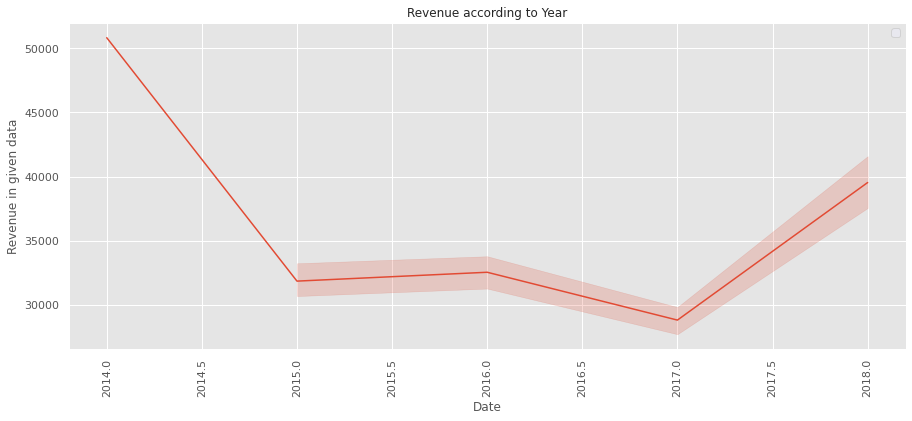

In [18]:
from matplotlib import style

fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

style.use('ggplot')

sns.lineplot(x=dataset["Year"], y=dataset["rev"], data=dataset)
sns.set(rc={'figure.figsize':(15,6)})

plt.title("Revenue in Years")
plt.xlabel("Date")
plt.ylabel("Revenue in given data")
plt.grid(True)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)


plt.title("Revenue according to Year")

In [23]:
dataset.Year.unique()

array([2014, 2015, 2016, 2017, 2018])

### Revenue Distribution

Text(0.5, 1.0, 'Revenue Distribution')

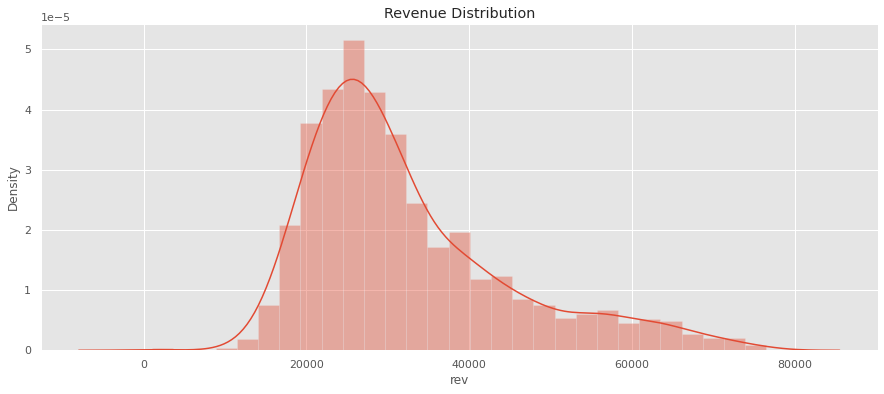

In [24]:
sns.distplot(dataset["rev"])
plt.title("Revenue Distribution")

I wish I could have more understanding of units and details.

### Revenue with Respect to Months

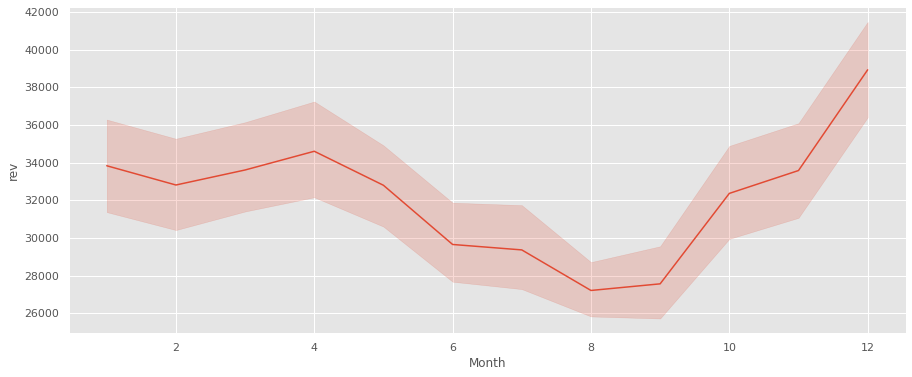

In [25]:
ax = sns.lineplot(x="Month", y="rev", data=dataset)

### Revenue with Respect to weeks

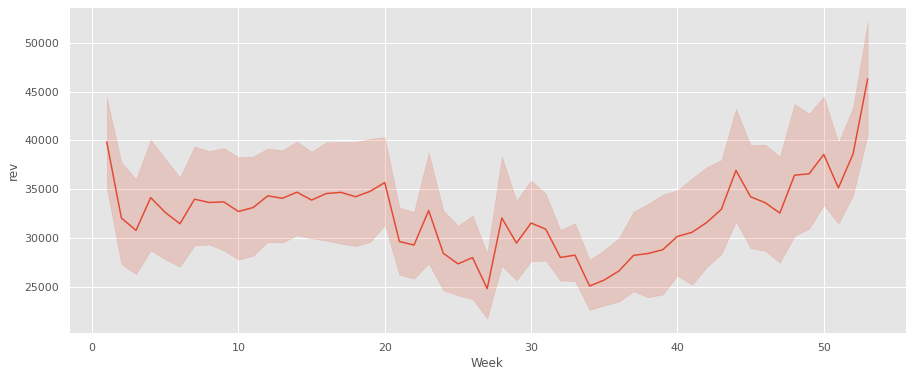

In [26]:
ax = sns.lineplot(x="Week", y="rev", data=dataset)

### Revenue with Respect to Day

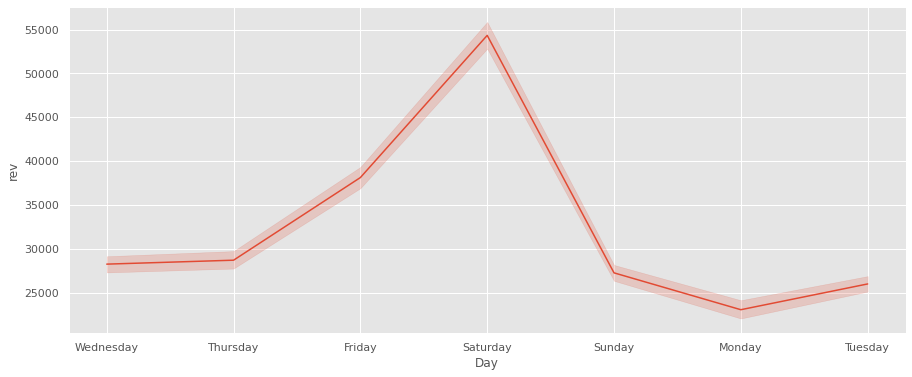

In [27]:
ax = sns.lineplot(x="Day", y="rev", data=dataset)

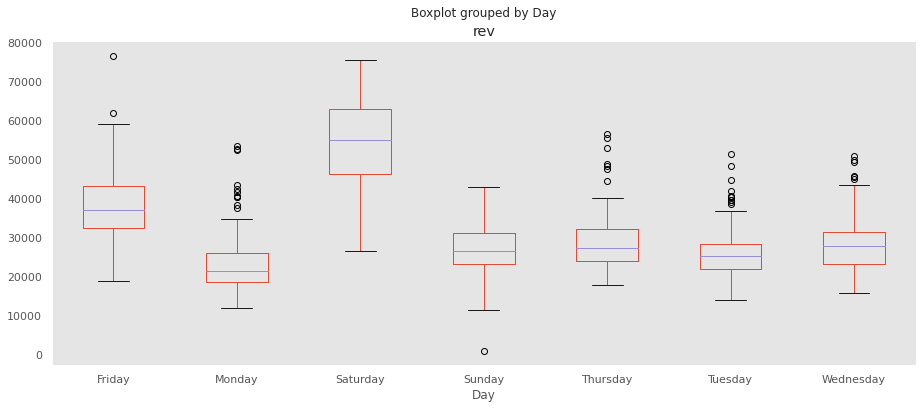

In [29]:
dataset.boxplot(by ='Day', column =['rev'], grid = False) 

### Distribution plot


 mu = 32279.48 and sigma = 12537.73



Text(0.5, 1.0, 'rev distribution')

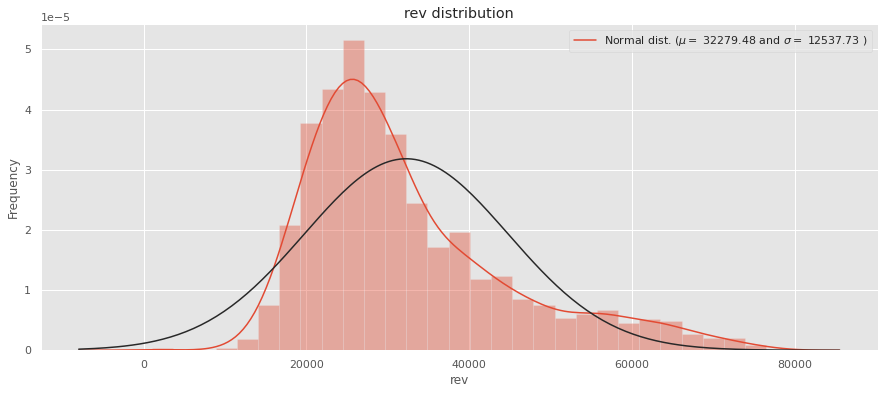

In [31]:
from scipy.stats import norm, skew
sns.distplot(dataset['rev'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(dataset['rev'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plotting the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('rev distribution')

### Density plot to check outliers

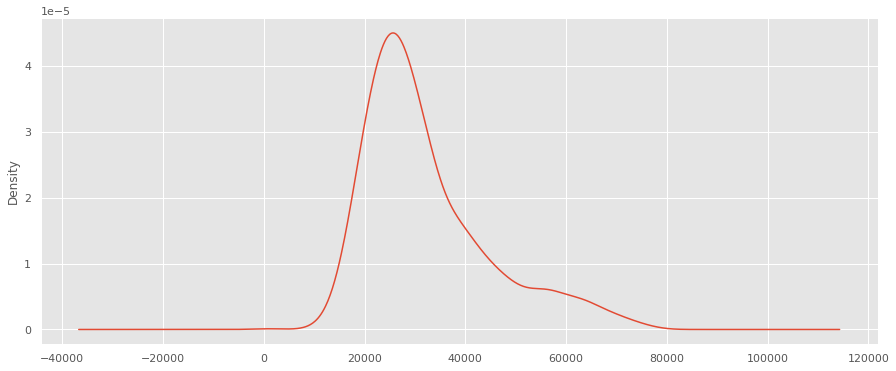

In [33]:
dataset.rev.plot(kind='density')

### BoxPlot

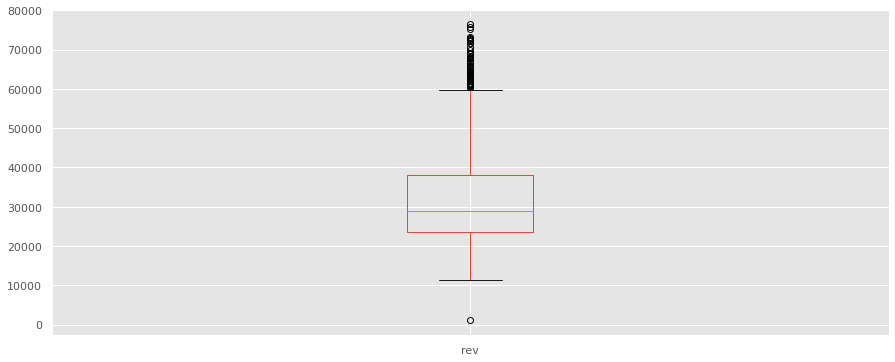

In [34]:
dataset.rev.plot(kind='box', subplots=True, layout=(1,1), sharex=False, sharey=False)
plt.show()

As we could see in describe, there are couple of outliers above 60K.

### Probability plot or QQ plot

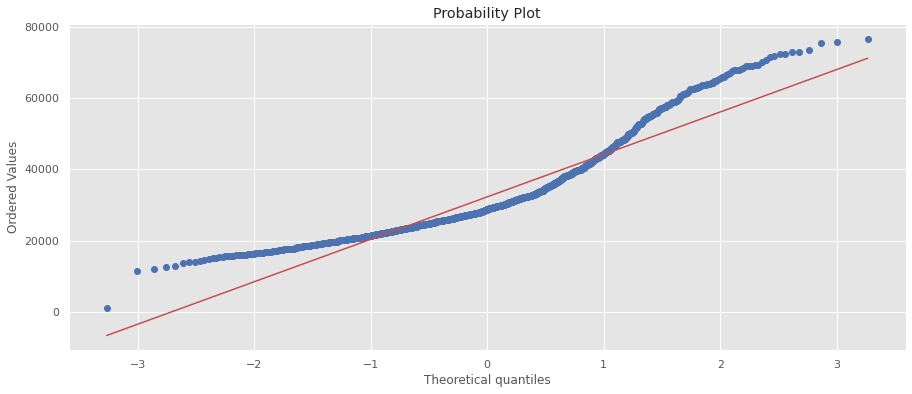

In [35]:
#Probability plot or QQ plot to see linear fit 
from scipy import stats
fig = plt.figure()
res = stats.probplot(dataset['rev'], plot=plt)
plt.show()

So now we are sure that outlier problem exists. Let's see what are those values using Tukey IQR method

### Tukey IQR

In [36]:
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

In [37]:
tukey_indices, tukey_values = find_outliers_tukey(dataset['rev'])
print(np.sort(tukey_values))

[ 1044.29 60558.58 60593.57 60603.58 60762.53 60988.98 61115.93 61158.41
 61322.95 61385.17 61594.29 61997.   62489.74 62623.29 62635.85 62644.14
 62781.35 62858.57 62859.26 62950.55 63029.15 63288.92 63585.73 63587.9
 63648.92 63669.33 63918.94 63964.63 63998.05 64300.31 64319.38 64649.67
 64798.85 64936.7  65410.88 65680.12 65773.44 65795.06 66571.11 66726.16
 67031.94 67531.03 67762.49 67790.12 67945.33 68178.8  68447.67 68926.4
 69045.26 69084.01 69121.96 69142.46 69957.06 70548.05 71607.43 71676.02
 72188.54 72334.16 72753.2  72970.15 73325.02 75331.43 75638.89 76535.87]


For these outliers, I will normalize data before putting to Model

# 4-Predictive Model 

In [72]:
# create variable to predict 14 days in future
future_days=14
# create new column i.e target data x days shifted
df["prediction"]=df[["rev"]].shift(-future_days)
df.head(3) 

,rev,prediction
Date,,
2014-12-31,50828.80,22482.89
2015-01-01,37500.11,24923.70
2015-01-02,48145.07,39677.33


In [73]:
df.isnull().sum()

rev            0
prediction    14
dtype: int64

In [74]:
# create feature dataste and convert to np array and remove last x days
X=np.array(df.drop(["prediction"],1))[:-future_days]

In [75]:
X[:5]

array([[50828.8 ],
       [37500.11],
       [48145.07],
       [58975.57],
       [28159.96]])

In [76]:
# create target dataset i.e y. Convert np.array and get all of the target values except last X days i.e 14 dAYS

y=np.array(df["prediction"])[:-future_days]
y[:5]

array([22482.89, 24923.7 , 39677.33, 56905.19, 24707.53])

In [77]:
print(X.shape)
print(y.shape)

(1259, 1)
(1259,)


In [78]:
# split train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [79]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1007, 1)
(252, 1)
(1007,)
(252,)


In [90]:
# Create model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
tree=RandomForestRegressor().fit(X_train,y_train)

In [91]:
# get last x rows of feature dataset
X_future=df.drop(["prediction"], 1)[:-future_days]

In [92]:
X_future=X_future.tail(future_days)

In [93]:
# convert to np array
X_future=np.array(X_future)
X_future[:10]

array([[21457.12],
       [30555.73],
       [30773.21],
       [29876.92],
       [44121.14],
       [53752.27],
       [28423.48],
       [22284.03],
       [28496.44],
       [32431.05]])

In [94]:
# show model tree prediction
tree_prediction=tree.predict(X_future)
print(tree_prediction)

[27250.9645 28740.3458 29018.8275 27964.0912 40949.3084 60337.5333
 22988.7563 24514.4455 27057.5731 29431.836  37442.8567 43859.6348
 59915.3596  7373.4964]


A More advanced level model could be used however; I have given basic idea about how prediction could be. Other model selection part was not part of this excercise.